In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from scipy import stats
from matplotlib.ticker import PercentFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import requests
import xarray as xr

In [2]:
#WUS 
Bbox= {'latmax':49.00,'latmin': 31.35,'lonmax': -101.96,'lonmin': -125.07}
latmax = Bbox['latmax']
latmin = Bbox['latmin']
lonmax = Bbox['lonmax']
lonmin = Bbox['lonmin']

#edit time period 
#dates
st = '2011-01-01'
ed = '2020-09-30'

#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

# CSO projection
stn_proj = 'epsg:4326'
gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

# get cso doy 
gdf['dt'] = pd.to_datetime(gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
gdf['dt'] = pd.to_datetime(gdf['dt']).dt.date

uapath = '/nfs/attic/dfh/data/UA_SWE/'
uaswe = [uapath+'4km_SWE_Depth_WY2017_v01.nc',uapath+'4km_SWE_Depth_WY2018_v01.nc',
         uapath+'4km_SWE_Depth_WY2019_v01.nc',uapath+'4km_SWE_Depth_WY2020_v01.nc']
ds = xr.merge([ xr.open_dataset(f).sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax)) for f in uaswe])
ds

<xarray.Dataset>
Dimensions:   (lat: 424, lon: 553, time: 1461, time_str_len: 11)
Coordinates:
  * time      (time) datetime64[ns] 2016-10-01 2016-10-02 ... 2020-09-30
  * lat       (lat) float32 31.375 31.416666 31.458334 ... 48.958332 49.0
  * lon       (lon) float32 -125.0 -124.958336 ... -102.041664 -102.0
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 b''
    time_str  (time_str_len, time) object b'0' b'0' b'0' b'0' ... b'0' b'0' b'0'
    SWE       (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    DEPTH     (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

# Depth

In [3]:
bias =[]
for i in range(len(gdf)):
    bias.append(ds.sel(lat=gdf.geometry.y.values[i],lon=gdf.geometry.x.values[i],time=gdf.dt.values[i],method='nearest').DEPTH.values-gdf.depth[i]*10)
    
gdf['bias']=bias

#masked array to remove nans so kde works
mbias = ma.masked_array(bias,np.isnan(bias))

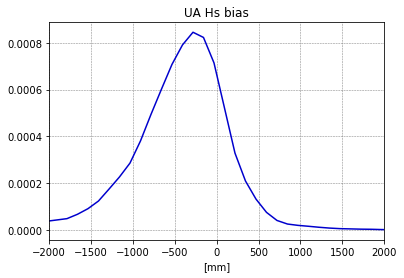

In [8]:
fig, axs = plt.subplots(1)  
data = np.array(mbias.compressed())
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'mediumblue')
axs.set_title('UA Hs bias')
axs.set_xlabel('[mm]')
axs.set_xlim([-2000,2000])
axs.grid(linestyle='--', linewidth='0.5', color='grey')

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_depth_bias.pdf'
fig.savefig(figpath, format='pdf', dpi=300)

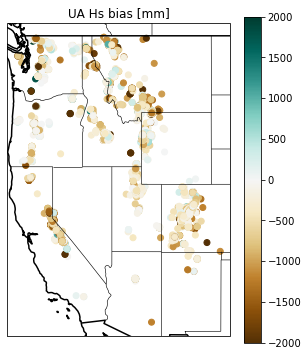

In [6]:
#states
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

bnd = gdf.geometry.bounds
stamen_terrain = cimgt.Stamen('terrain')
dx=1.4
dy=0.4

fig, ax = plt.subplots(
    figsize=(5, 6), subplot_kw={"projection": stamen_terrain.crs}
)
#ax.set_extent([bnd.minx.min() - dx, bnd.maxx.max() + dx, bnd.miny.min() - dy, bnd.maxy.max() + dy])
#ax.add_image(stamen_terrain, 9)
ax.add_feature(states_provinces,edgecolor='k',linewidth=.6)#,linestyle=':')
ax.add_feature(cfeature.BORDERS,edgecolor='k',linewidth=1.5)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.5)
ax.set_title('UA Hs bias [mm]')

gdf.plot(ax=ax, column='bias', cmap = 'BrBG',legend=True, transform=ccrs.PlateCarree(),vmin=-2000,vmax=2000)

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_depth_bias_map.pdf'
fig.savefig(figpath, format='pdf', dpi=300)

# SWE

In [3]:
gdf['Y'] = pd.DatetimeIndex(gdf['dt']).year
gdf['M'] = pd.DatetimeIndex(gdf['dt']).month
gdf['D'] = pd.DatetimeIndex(gdf['dt']).day
gdf["LON"] = gdf.geometry.x
gdf["LAT"] = gdf.geometry.y
#convert snow depth to mm to input into density function
gdf['H'] = gdf.depth*10

gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,dt,Y,M,D,LON,LAT,H
0,POINT (-105.87730 39.57150),RLTwMLaM,Pat Hansen,70.0,SnowPilot,2020-12-15T22:00:00.000Z,3379.251709,2020-12-15,2020,12,15,-105.877300,39.571500,700.0
1,POINT (-114.33260 48.50330),P2zhKIwo,Jeremiah Primmer,107.0,SnowPilot,2020-12-15T22:00:00.000Z,1698.080444,2020-12-15,2020,12,15,-114.332600,48.503300,1070.0
2,POINT (-110.92611 45.82751),yn7Dr0mp,Owen Miller,80.0,SnowPilot,2020-12-15T22:00:00.000Z,2094.295654,2020-12-15,2020,12,15,-110.926109,45.827512,800.0
3,POINT (-110.96955 43.50077),YvtYk5nZ,Grant Henarie,47.0,SnowPilot,2020-12-15T22:00:00.000Z,2583.323730,2020-12-15,2020,12,15,-110.969553,43.500773,470.0
4,POINT (-111.57390 40.60610),HFbPKpZz,McKinley Talty,115.0,SnowPilot,2020-12-15T21:15:00.000Z,2759.891846,2020-12-15,2020,12,15,-111.573900,40.606100,1150.0


In [ ]:
from Depth2SWE import swe_calc
SWE,DOY = swe_calc(gdf.Y.values,gdf.M.values,gdf.D.values,gdf.H.values,gdf.LAT.values,gdf.LON.values)

gdf['swe']=SWE
gdf['doy']=DOY

In [ ]:
swebias =[]
for i in range(len(gdf)):
    swebias.append(ds.sel(lat=gdf.geometry.y.values[i],lon=gdf.geometry.x.values[i],time=gdf.dt.values[i],method='nearest').SWE.values-gdf.swe[i]*10)
    
gdf['swe_bias']=swebias

#masked array to remove nans so kde works
mswebias = ma.masked_array(swebias,np.isnan(swebias))

In [ ]:
fig, axs = plt.subplots(1)  
data = np.array(mswebias.compressed())
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'mediumblue')
axs.set_title('UA SWE bias')
axs.set_xlabel('[mm]')
#axs.set_xlim([-2000,2000])
axs.grid(linestyle='--', linewidth='0.5', color='grey')

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_swe_bias.pdf'
fig.savefig(figpath, format='pdf', dpi=300)

In [ ]:
#states
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

bnd = gdf.geometry.bounds
stamen_terrain = cimgt.Stamen('terrain')
dx=1.4
dy=0.4

fig, ax = plt.subplots(
    figsize=(5, 6), subplot_kw={"projection": stamen_terrain.crs}
)
#ax.set_extent([bnd.minx.min() - dx, bnd.maxx.max() + dx, bnd.miny.min() - dy, bnd.maxy.max() + dy])
#ax.add_image(stamen_terrain, 9)
ax.add_feature(states_provinces,edgecolor='k',linewidth=.6)#,linestyle=':')
ax.add_feature(cfeature.BORDERS,edgecolor='k',linewidth=1.5)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.5)
ax.set_title('UA SWE bias [mm]')

gdf.plot(ax=ax, column='swe_bias', cmap = 'BrBG',legend=True, transform=ccrs.PlateCarree(),vmin=-500,vmax=500)

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_swe_bias_map.pdf'
fig.savefig(figpath, format='pdf', dpi=300)